- 스트리밍 복제에는 로그 전달과 데이터베이스 동기화라는 두 가지 측면이 있음.
- 로그 전달은 스트리밍 복제의 주요 측면.
  - 기본 서버는 WAL(Write-Ahead Log) 데이터가 기록될 때마다 연결된 대기 서버에 데이터를 전송하기 때문.
  - 데이터베이스 동기화는 기본 서버가 각 대기 서버와 통신하여 데이터베이스 클러스터를 동기화하는 동기 복제에 필요.

- 스트리밍 복제가 어떻게 작동하는지 정확하게 이해하려면 하나의 기본 서버가 여러 대기 서버를 관리하는 방법을 이해해야 함.
- 이번 섹션에서는 간단한 사례(즉, 단일-1차 단일-대기 시스템)부터 시작하고, 다음 섹션에서는 일반적인 사례(단일-1차 다중 대기 시스템)에 대해 기술

# **Communication Between a Primary and a Synchronous Standby**

- 대기 서버가 동기 복제 모드에 있지만 구성 매개변수 hot_standby가 비활성화되고 wal_level 이 ' replica '라고 가정합니다. 기본 서버의 주요 매개변수는 다음과 같음.



```
synchronous_standby_names = 'standby1'
hot_standby = off
wal_level = replica
```

- WAL 데이터를 작성하는 세 가지 트리거 중에서 여기서는 트랜잭션 커밋에 중점을 둠.

- 기본 서버의 한 백엔드 프로세스가 자동 커밋 모드에서 간단한 INSERT 문을 실행한다고 가정
  - 백엔드는 트랜잭션을 시작하고 INSERT 문을 실행한 다음 즉시 트랜잭션을 커밋.

**Streaming Replication's communication sequence diagram.**

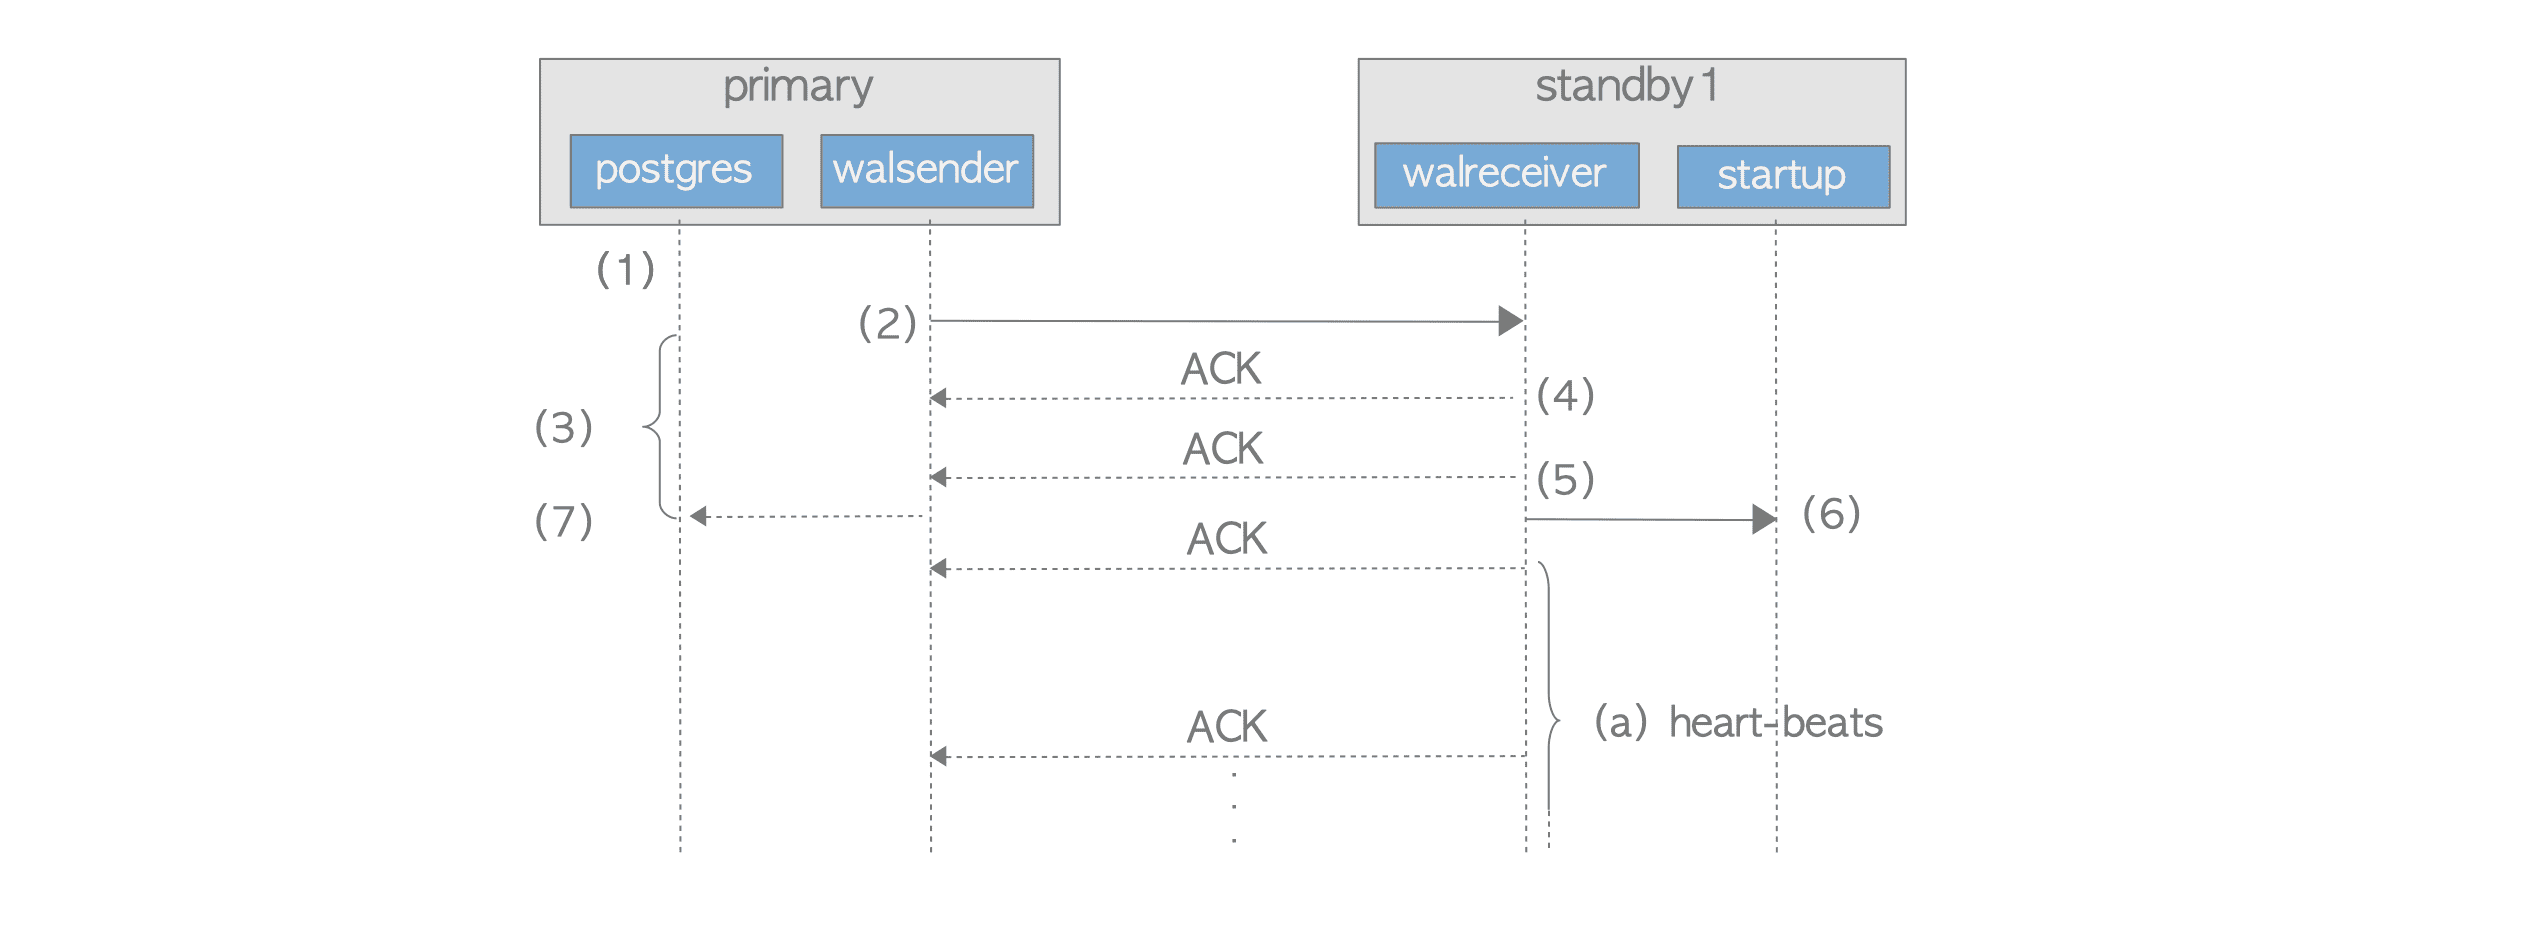

1. 백엔드 프로세스는 XLogInsert() 및 XLogFlush() 함수를 실행하여 WAL 데이터를 WAL 세그먼트 파일에 쓰고 플러시

2. walsender 프로세스는 WAL 세그먼트에 작성된 WAL 데이터를 walreceiver 프로세스로 보냄.

3. WAL 데이터를 보낸 후 백엔드 프로세스는 대기 서버의 ACK 응답을 계속 기다림.
  - 보다 정확하게는 백엔드 프로세스는 내부 함수 SyncRepWaitForLSN() 을 실행하여 래치를 획득 하고 해제될 때까지 기다림.

4. 대기 서버의 walreceiver는 write() 시스템 호출을 사용하여 수신한 WAL 데이터를 대기 서버의 WAL 세그먼트에 쓰고 ack 응답을 walsender에게 반환.

5. walreceiver는 fsync() 와 같은 시스템 호출을 사용하여 WAL 데이터를 WAL 세그먼트로 플러시하고 walsender에 또 다른 ACK 응답을 반환하며 업데이트된 WAL 데이터에 대해 시작 프로세스에 알림.

6. 시작 프로세스는 WAL 세그먼트에 기록된 WAL 데이터를 재생.

7. Walsender는 Walreceiver로부터 ACK 응답을 받으면 백엔드 프로세스의 래치를 해제하고 백엔드 프로세스의 커밋 또는 중단 작업이 완료됨.
  - 래치 해제 타이밍은 synchronous_commit 매개변수에 따라 달라짐.
  - 'on' (기본값)이면 단계(5)의 ACK가 수신되면 래치가 해제되는 반면, 'remote_write' 이면 단계(4)의 ACK가 수신되면 래치가 해제됨.

- 각 ACK 응답은 대기 서버의 내부 정보를 기본 서버에 알려줌.

**4가지 항목이 포함**

- 최신 WAL 데이터가 기록된 LSN 위치.
- 최신 WAL 데이터가 플러시된 LSN 위치.
- 시작 프로세스에서 최신 WAL 데이터가 재생된 LSN 위치.
- 이 응답이 전송된 타임스탬프.

**XLogWalRcvSendReply**

```

XLogWalRcvSendReply(void)@src/backend/replication/walreceiver.c
	/* Construct a new message */
	writePtr = LogstreamResult.Write;
	flushPtr = LogstreamResult.Flush;
	applyPtr = GetXLogReplayRecPtr(NULL);

	resetStringInfo(&reply_message);
	pq_sendbyte(&reply_message, 'r');
	pq_sendint64(&reply_message, writePtr);
	pq_sendint64(&reply_message, flushPtr);
	pq_sendint64(&reply_message, applyPtr);
	pq_sendint64(&reply_message, GetCurrentTimestamp());
	pq_sendbyte(&reply_message, requestReply ? 1 : 0);
```

- Walreceiver는 WAL 데이터가 기록되고 플러시될 때뿐만 아니라 대기 서버의 하트비트로 주기적으로 ACK 응답을 반환
  - 따라서 기본 서버는 항상 연결된 모든 대기 서버의 상태를 정확하게 이해하고 있음.

- 연결된 대기 서버의 LSN 관련 정보는 아래와 같은 쿼리를 실행하여 표시할 수 있음.

```
testdb=# SELECT application_name AS host,
        write_location AS write_LSN, flush_location AS flush_LSN,
        replay_location AS replay_LSN FROM pg_stat_replication;

   host   | write_lsn | flush_lsn | replay_lsn
----------+-----------+-----------+------------
 standby1 | 0/5000280 | 0/5000280 | 0/5000280
 standby2 | 0/5000280 | 0/5000280 | 0/5000280
(2 rows)
```

**Info**

- 하트비트 간격은 wal_receiver_status_interval 매개변수로 설정되며 기본적으로 10초.

# **Behavior When a Failure Occurs**

이 하위 섹션에서는 동기식 대기 서버에 장애가 발생했을 때 기본 서버가 어떻게 작동하는지, 그리고 상황을 처리하는 방법에 대해 설명합니다.

동기식 대기 서버가 실패하여 더 이상 ACK 응답을 반환할 수 없는 경우에도 기본 서버는 계속해서 응답을 기다립니다. 이는 실행 중인 트랜잭션을 커밋할 수 없으며 후속 쿼리 처리를 시작할 수 없음을 의미합니다. 즉, 모든 기본 서버 작업이 효과적으로 중지됩니다. (스트리밍 복제는 타임아웃 후 자동으로 비동기 모드로 복귀하는 기능을 지원하지 않습니다.)

그러한 상황을 피하는 방법에는 두 가지가 있습니다. 하나는 여러 대기 서버를 사용하여 시스템 가용성을 높이는 것입니다. 다른 하나는 다음 단계를 수행하여 동기 모드 에서 비동기 모드로 수동으로 전환하는 것입니다 .

(1) synchronous_standby_names 매개변수를 빈 문자열로 설정합니다.

synchronous_standby_names = ''
(2) 다시 로드 옵션을 사용하여 pg_ctl 명령을 실행합니다 .

postgres> pg_ctl -D $PGDATA reload
이 절차는 연결된 클라이언트에 영향을 주지 않습니다. 기본 서버는 계속해서 트랜잭션을 처리하며 클라이언트와 해당 백엔드 프로세스 간의 모든 세션이 유지됩니다.